In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bugdatasets import datasets as bugds

# Load MNIST dataset with wavefield
dataset = bugds.HelmholtzMNIST()
dataset.load("omega_0.25_image_size_128")

In [3]:
fields = [dataset[i]["field"][2::4,2::4] for i in range(len(dataset))]
del dataset

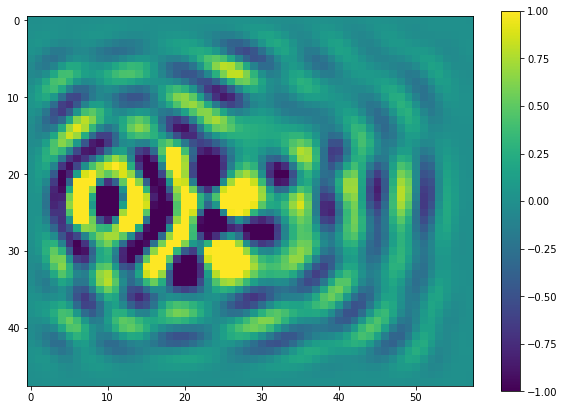

In [13]:
from matplotlib import pyplot as plt

# Example field
plt.figure(figsize=(10,7))
plt.imshow(fields[0].imag, vmin=-1, vmax=1)
plt.colorbar()

In [14]:
from jaxdf.discretization import FourierSeries, FiniteDifferences
from jaxdf.geometry import Domain
from jaxdf.core import Field

# Define domain
shape = fields[0].shape[:-1]
domain = Domain(shape, (1., 1.))

# Define discretizations
fourier_discretization = FourierSeries(domain)
fd_discretization = FiniteDifferences(domain)

# Generate fields for compiling the fields
u_params, u = fourier_discretization.empty_field(name="u")
v_params, v = fd_discretization.empty_field(name="u")

In [15]:
from jaxdf import operators as jops
from jaxdf.core import operator

# Simple gradient operator
@operator()
def custom_op(u):
    grad_u = jops.gradient(u)
    return grad_u

In [16]:
op = custom_op(u=u)
grad_fourier = op.get_field_on_grid(0)
global_params_fourier = op.get_global_params()

In [17]:
op = custom_op(u=v)
grad_fd = op.get_field_on_grid(0)
global_params_fd = op.get_global_params()
print(op)

DiscretizedOperator :: [FiniteDifferences], ['_k5'] 

 Input fields: ('u',)

Globals: Shared: {}
Independent: {'FDGradient_jR': {'gradient_kernel': DeviceArray([-0.08333334,  0.6666667 ,  0.        , -0.6666667 ,
              0.08333334], dtype=float32)}}

Operations:
- _k5: FiniteDifferences <-- FDGradient ('u',) | (independent) FDGradient_jR



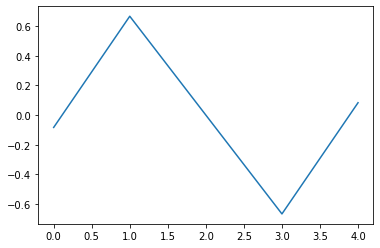

In [18]:
k = global_params_fd["independent"]['FDGradient_jR']['gradient_kernel']
plt.plot(k)

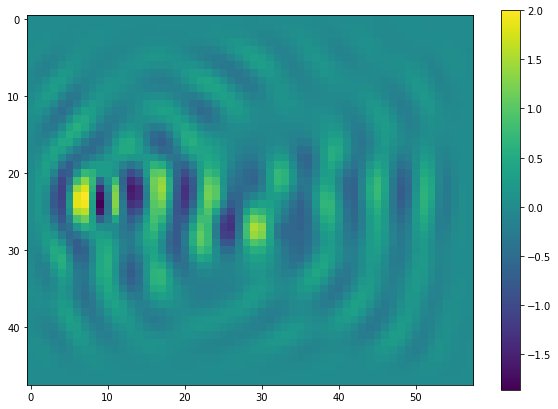

In [19]:
a = grad_fd(global_params_fd, {"u": fields[0]})
plt.figure(figsize=(10,7))
plt.imshow(a.real[...,1])
plt.colorbar()

In [20]:
from jax import numpy as jnp
from jax import grad, jit, value_and_grad

@jit
def loss(kernel, field):
    # Subsample field
    field = field
    
    # Fourier derivative
    fourier_deriv = grad_fourier(global_params_fourier, {"u": field})
    
    # FD derivative
    g_params = global_params_fd.copy()
    g_params["independent"]['FDGradient_jR']['gradient_kernel'] = kernel
    fd_deriv = grad_fd(g_params, {"u": field})
    
    # Error
    return jnp.sum(jnp.abs(fourier_deriv - fd_deriv)**2)

In [21]:
loss(k, fields[0])

DeviceArray(8.866144, dtype=float32)

In [22]:
from jax.example_libraries import optimizers

init_fun, update_fun, get_params = optimizers.adam(.001, b1=0.9, b2=0.9)
opt_state = init_fun(jnp.asarray(k))

In [23]:
@jit
def update(opt_state, field, i):
    lossval, gradient = value_and_grad(loss, argnums=0)(get_params(opt_state), field)
    return lossval, update_fun(i, gradient, opt_state)

In [24]:
len(fields)

10000

In [25]:
avg_loss = 0
for epoch in range(10):
    for i in range(9000):
        lossval, opt_state = update(opt_state, fields[i], i)
        avg_loss += lossval
        if i%500 == 499:
            avg_loss = avg_loss/500
            print(epoch, i, avg_loss)

2021-11-01 16:55:00.250370: E external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:518] Unable to compare 2#TC against 2 for %custom-call.6 = (f32[1,1,1,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,1,48,58]{3,2,1,0} %add.75, f32[1,1,48,58]{3,2,1,0} %copy.20), window={size=1x5 pad=0_0x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="conv_general_dilated" op_name="jit(update)/jit(transpose(jvp(loss)))/conv_general_dilated[ batch_group_count=1\n                                                            dimension_numbers=ConvDimensionNumbers(lhs_spec=(1, 0, 2, 3), rhs_spec=(1, 0, 2, 3), out_spec=(1, 0, 2, 3))\n                                                            feature_group_count=1\n                                                            lhs_dilation=(1, 1)\n                                                            lhs_shape=(1, 1, 48, 58)\n                                                  

RuntimeError: INTERNAL: Failed to load in-memory CUBIN: CUDA_ERROR_OUT_OF_MEMORY: out of memory

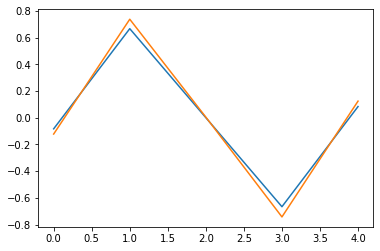

In [21]:
new_k = get_params(opt_state)

plt.plot(k)
plt.plot(new_k)

In [92]:
loss(k, fields[0])

DeviceArray(0.59752333, dtype=float32)

In [7]:
from jax import make_jaxpr, jit
from jax import numpy as jnp

f = op.get_field_on_grid(0)
global_params = op.get_global_params()

make_jaxpr(f)(global_params, {"u": u_params})

{ lambda  ; a b.
  let c = broadcast_in_dim[ broadcast_dimensions=(1,)
                            shape=(1, 5) ] a
      d = transpose[ permutation=(1, 0) ] c
      e = lt 0 0
      f = add 0 1
      g = select e f 0
      h = broadcast_in_dim[ broadcast_dimensions=(  )
                            shape=(1,) ] g
      i = gather[ dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1), collapsed_slice_dims=(2,), start_index_map=(2,))
                  indices_are_sorted=True
                  slice_sizes=(16, 16, 1)
                  unique_indices=True ] b h
      j = broadcast_in_dim[ broadcast_dimensions=(0, 1)
                            shape=(16, 16) ] i
      k = convert_element_type[ new_dtype=complex64
                                weak_type=False ] d
      l = xla_call[ backend=None
                    call_jaxpr={ lambda  ; a.
                                 let b = rev[ dimensions=(0, 1) ] a
                                 in (b,) }
                    device=None


In [22]:
!pip install scikit-image

     |████████████████████████████████| 34.6 MB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 175 kB 111.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 38.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 83.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 100.0 MB/s eta 0:00:01


In [24]:
from bugdatasets import datasets as bugds
dataset = bugds.HelmholtzMNIST()
dataset.load("omega_0.25_image_size_128")

In [25]:
len(dataset)

10000

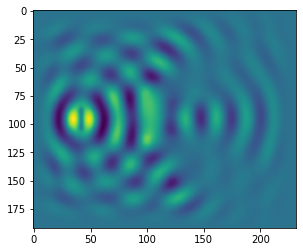

In [29]:
from matplotlib import pyplot as plt

plt.imshow(dataset[100]["field"].real)

In [30]:
dataset[100]["field"].shape

(192, 232, 1)

In [41]:
a = f(global_params, {"u": u_params})
print(a.shape)

(16, 16, 2)


In [5]:
class AddScalar(Primitive):
    def __init__(self, scalar, name="AddScalar", independent_params=True):
        super().__init__(name, independent_params)
        self.scalar = scalar
    
    def discrete_transform(self):
        def f(op_params, field_params):
            return [field_params, op_params["scalar"]]
        f.__name__ = self.name
        return f

    def setup(self, field):
        '''New arbitrary discretization'''
        parameters = {"scalar": self.scalar}

        def get_field(p_joined, x):
            p, scalar = p_joined
            return field.discretization.get_field()(p,x) + scalar

        new_discretization = discretization.Arbitrary(
            field.discretization.domain,
            get_field,
            no_init
        )

        return parameters, new_discretization


NameError: name 'Primitive' is not defined

In [ ]:
class AddScalarLinear(Primitive):
    def __init__(self, scalar, name="AddScalarLinear", independent_params=True):
        super().__init__(name, independent_params)
        self.scalar = scalar

    def discrete_transform(self):
        def f(op_params, field_params):
            return field_params + op_params["scalar"]
        f.__name__ = self.name
        return f
    
    def setup(self, field):
        '''Same discretization family as the input'''
        new_discretization = field.discretization
        parameters = {"scalar": self.scalar}
        return parameters, new_discretization

In [6]:
from jaxdf.core import operator

@operator(u)
def custom_op(x):
    return u(x) + 2

In [7]:
from jaxdf.core import operator

@operator()
def custom_op(u):
    a = u + 2
    return a

In [8]:
custom_op

<function jaxdf.core.operator.<locals>.decorator.<locals>.wrapper(*args, **kwargs)>

In [9]:
op = custom_op(u=u)
print(op)

DiscretizedOperator :: [RealFourierSeries], ['_k5'] 

 Input fields: ('u',)

Globals: Shared: {}
Independent: {'AddScalarLinear_jR': {'scalar': 2}}

Operations:
- _k5: RealFourierSeries <-- AddScalarLinear ('u',) | (independent) AddScalarLinear_jR



In [10]:
global_params = op.get_global_params()

f = op.get_field(0)
f(global_params, {'u': u_params}, x=1.)

DeviceArray([2240.], dtype=float32)

In [7]:
from jaxdf.core import operator
from jaxdf.primitives import AddScalarLinear

add_three = AddScalarLinear(scalar=3.)
add_five = AddScalarLinear(scalar=5., independent_params = False)

@operator(debug=False)
def custom_op(u):
    a = u + 2
    b = add_three(a)
    c = add_five(b)
    return c

In [8]:
from jaxdf.core import Field

# Fourier discretization
seeds = random.split(seed, 2)
u_params = fourier_discretization.random_field(seeds[0])
u = Field(fourier_discretization, params=u_params, name='u')

# Compiling operator on the given discretization
op = custom_op(u=u)
print(op)

DiscretizedOperator :: [RealFourierSeries], ['_oj'] 

 Input fields: ('u',)

Globals: Globals: 
{'shared': {'AddScalarLinear': {'scalar': 5.0}}, 'independent': {'AddScalarLinear_jR': {'scalar': 2}, 'AddScalarLinear_l5': {'scalar': 3.0}}}

Operations:
- _k5: RealFourierSeries <-- AddScalarLinear ('u',) | (independent) AddScalarLinear_jR
- _mO: RealFourierSeries <-- AddScalarLinear ('_k5',) | (independent) AddScalarLinear_l5
- _oj: RealFourierSeries <-- AddScalarLinear ('_mO',) | (shared) AddScalarLinear



In [9]:
global_params = op.get_global_params()

f = op.get_field(0)
f(global_params, {'u': u_params}, 1.)

DeviceArray([8.997641], dtype=float32)

In [13]:
import pprint

pp = pprint.PrettyPrinter(indent=4)

In [14]:
pp.pprint(global_params)

{   'independent': {   'AddScalarLinear_jR': {'scalar': 2},
                       'AddScalarLinear_l5': {'scalar': 3.0}},
    'shared': {'AddScalarLinear': {'scalar': 5.0}}}


In [15]:
from jaxdf.primitives import Primitive

In [9]:
class MultiplyScalarLinear(Primitive):
    def __init__(self, scalar, name="MultiplyScalarLinear", independent_params=True):
        super().__init__(name, independent_params)
        self.scalar = scalar

    def discrete_transform(self):
        def f(op_params, field_params):
            return field_params  op_params["scalar"]
        f.__name__ = self.name
        return f
    
    def setup(self, field):
        '''Same discretization family as the input'''
        new_discretization = field.discretization
        parameters = {"scalar": self.scalar}
        return parameters, new_discretization

In [33]:
class PowerScalarLinear(Primitive):
    def __init__(self, exponent, name="abc", independent_params=True):
        super().__init__(name, independent_params)
        self.exponent = exponent
        
    def setup(self, field):
        '''Same discretization family as the input'''
        new_discretization = field.discretization
        parameters = {"exponent": self.exponent}
        return parameters, new_discretization
    
    def discrete_transform(self):
        def f(op_params, field_params):
            return field_params*op_params["exponent"]
        f.__name__ = self.name
        return f

In [34]:
power_4 = PowerScalarLinear(4)
    
@operator(debug=False)
def custom_op(u):
    b = power_4(u)
    c = b + 10
    return c

In [35]:
op = custom_op(u=u)
print(op)

DiscretizedOperator :: [RealFourierSeries], ['_mO'] 

 Input fields: ('u',)

Globals: {'shared': {}, 'independent': {'abc_jR': {'exponent': 4}, 'AddScalarLinear_l5': {'scalar': 10}}}

Operations:
- _k5: RealFourierSeries <-- abc ('u',) | (independent) abc_jR
- _mO: RealFourierSeries <-- AddScalarLinear ('_k5',) | (independent) AddScalarLinear_l5



In [36]:
global_params = op.tracer.globals.dict
f = op.get_field(0)
f(global_params, {'u': u_params}, 1.)g

DeviceArray(5.990572, dtype=float32)

In [37]:
def g(exponent):
    new_global = global_params.copy()
    new_global['independent']['abc_jR']['exponent'] = exponent
    return f(new_global, {'u': u_params}, 1.)

In [38]:
g(3.)

DeviceArray(6.992928, dtype=float32)

In [39]:
from jax import grad

dg = grad(g)

In [40]:
dg(3.)

DeviceArray(-1.0023577, dtype=float32)

In [30]:
jax.make_jaxpr(f)(global_params, {'u': u_params}, 1.)

{ lambda a b c d e ; f g h i.
  let j = convert_element_type[ new_dtype=float32
                                weak_type=False ] g
      k = pow h j
      l = convert_element_type[ new_dtype=float32
                                weak_type=False ] f
      m = add k l
      n = broadcast_in_dim[ broadcast_dimensions=(  )
                            shape=(32,) ] 0.0
      o = convert_element_type[ new_dtype=float32
                                weak_type=False ] a
      p = broadcast_in_dim[ broadcast_dimensions=(  )
                            shape=(1,) ] 0
      q = scatter[ dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0,), inserted_window_dims=(), scatter_dims_to_operand_dims=(0,))
                   indices_are_sorted=False
                   unique_indices=True
                   update_consts=(  )
                   update_jaxpr={ lambda  ; a b.
                                  let 
                                  in (b,) } ] n p o
      r = convert_elemen

In [1]:
jax.make_jaxpr(f)(global_params, {'u': u_params}, 1.)

NameError: name 'jax' is not defined

# jax.make_jaxpr(f)(global_params, {'u': u_params}, 1.)

In [23]:
pp.pprint(global_params)

{   'independent': {   'AddScalarLinear_l5': {'scalar': 10},
                       'abc_jR': {'exponent': 4}},
    'shared': {}}
